In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import tensorflow as tf

from tqdm import tqdm 
import numpy as np
import re
import string

In [ ]:
path_to_file = keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
with open(path_to_file) as f:
    corpus = f.read().splitlines()
len(corpus)

40000

In [ ]:
corpus[:5]

['First Citizen:',
 'Before we proceed any further, hear me speak.',
 '',
 'All:',
 'Speak, speak.']

In [ ]:
corpus = [line for line in corpus if line != '']

In [ ]:
corpus_text = text_to_word_sequence(' '.join(i for i in corpus))

In [ ]:
corpus[:10]

['First Citizen:',
 'Before we proceed any further, hear me speak.',
 'All:',
 'Speak, speak.',
 'First Citizen:',
 'You are all resolved rather to die than to famish?',
 'All:',
 'Resolved. resolved.',
 'First Citizen:',
 'First, you know Caius Marcius is chief enemy to the people.']

In [ ]:
corpus_text[:5]

['first', 'citizen', 'before', 'we', 'proceed']

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(corpus_text)

In [ ]:
stoi = tokenizer.word_index
stoi['<pad>'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
numericalized = [[stoi[w] for w in text_to_word_sequence(doc)] for doc in corpus]

In [ ]:
vocab_size = len(stoi)
embed_size = 100
window_size = 2

print(f"Vocab Size  : {vocab_size}")
print(f"Vocab Sample: {list(stoi.items())[:5]}")

Vocab Size  : 12633
Vocab Sample: [('the', 1), ('and', 2), ('to', 3), ('i', 4), ('of', 5)]


In [ ]:
def generate_context_target_pairs(corpus=numericalized, window_size=2, vocab_size=vocab_size):
    
    context_length = window_size * 2
    
    for sentence in corpus:
        sentence_length = len(sentence)
        
        for index, word in enumerate(sentence):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([sentence[i] for i in range(start, end)
                                 if 0 <= i < sentence_length and i != index])
            label_word.append(word)
            
            x = pad_sequences(context_words, maxlen=context_length)
            y = to_categorical(label_word, vocab_size)
            yield(x[0], y[0])

In [ ]:
i = 0
for x, y in generate_context_target_pairs(numericalized, 2, vocab_size):
    if 0 not in x:
        if i == 10: break
        i+=1

        print(f'Target: {itos[np.argmax(y)]}, Context: {[itos[w] for w in x]}')

Target: proceed, Context: ['before', 'we', 'any', 'further']
Target: any, Context: ['we', 'proceed', 'further', 'hear']
Target: further, Context: ['proceed', 'any', 'hear', 'me']
Target: hear, Context: ['any', 'further', 'me', 'speak']
Target: all, Context: ['you', 'are', 'resolved', 'rather']
Target: resolved, Context: ['are', 'all', 'rather', 'to']
Target: rather, Context: ['all', 'resolved', 'to', 'die']
Target: to, Context: ['resolved', 'rather', 'die', 'than']
Target: die, Context: ['rather', 'to', 'than', 'to']
Target: than, Context: ['to', 'die', 'to', 'famish']


In [ ]:
dataset = tf.data.Dataset.from_generator(generate_context_target_pairs, (tf.int16, tf.int16)).batch(100000)

In [ ]:
for batch, (x, y) in enumerate(dataset):
  break
print("batch: ", batch)
x.shape, y.shape

KeyboardInterrupt: ignored

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2),
    Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embed_size)),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 4, 100)            1263300   
_________________________________________________________________
lambda_8 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 12633)             1275933   
Total params: 2,539,233
Trainable params: 2,539,233
Non-trainable params: 0
_________________________________________________________________


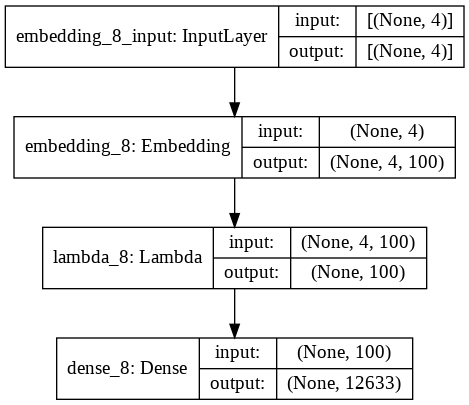

In [ ]:
from tensorflow.keras.utils import plot_model 
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
bmodel.fit(x, y, epochs=100)

Epoch 1/100
3125/3125 [==============================] - 35s 11ms/step - loss: 7.5198
Epoch 2/100
3125/3125 [==============================] - 35s 11ms/step - loss: 6.4307
Epoch 3/100
3125/3125 [==============================] - 35s 11ms/step - loss: 6.0635
Epoch 4/100
3125/3125 [==============================] - 35s 11ms/step - loss: 5.7631
Epoch 5/100
3125/3125 [==============================] - 35s 11ms/step - loss: 5.5080
Epoch 6/100
3125/3125 [==============================] - 35s 11ms/step - loss: 5.3037
Epoch 7/100
3125/3125 [==============================] - 35s 11ms/step - loss: 5.1054
Epoch 8/100
3125/3125 [==============================] - 35s 11ms/step - loss: 4.9008
Epoch 9/100
3125/3125 [==============================] - 35s 11ms/step - loss: 4.7219
Epoch 10/100
3125/3125 [==============================] - 35s 11ms/step - loss: 4.5555
Epoch 11/100
3125/3125 [==============================] - 35s 11ms/step - loss: 4.3803
Epoch 12/100
2102/3125 [===================>........

KeyboardInterrupt: ignored

In [ ]:
sentence = 'rather to than to'.split()
idx = [stoi[i] for i in sentence]

In [ ]:
sentence

['rather', 'to', 'than', 'to']

In [ ]:
[idx]

[[350, 3, 63, 3]]

In [ ]:
output = model.predict([idx])

In [ ]:
output.shape

(1, 12633)

In [ ]:
itos[output.argmax(axis=1)[0]]

'be'